### Fitting the Model To the Data

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
from collections import namedtuple
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import matplotlib.cm as cm
import matplotlib.colors as c

# Own imports from utils and visualizations file
from utils import *
from visualizations import *

In [2]:
# Load in the configuration dictionary
config_dict = LoadYAMLFile('config-file.yaml')
 
# For reproducibility, define a seed
seed = config_dict['general']['seed']
np.random.seed(seed)

### Parameters that won't change ###
num_groups = 3  # The number of modules in the defined space
n_dim = config_dict['general']['n_dim'] # Number of dimensions for the physical space that the neurons inhabit
radius = config_dict['general']['radius'] # Width of the physical space that the neurons can inhabit in each dimension. Equidistant in all dimensions. 

### Parameters for implementing modules ###
n = config_dict['general']['n']
n_per_group = config_dict['general']['n_per_group'] # Number of neurons in each module if that exists
module_std = config_dict['general']['module_std'] # The standard deviation of the node positions within a module
x1_mean = config_dict['general']['x1_mean'] # Center in x dimension for 3 modules
x2_mean = config_dict['general']['x2_mean']
x3_mean = config_dict['general']['x3_mean']
y1_mean = config_dict['general']['y1_mean'] # Center in y dimension for 3 modules
y2_mean = config_dict['general']['y2_mean']
y3_mean = config_dict['general']['y3_mean']
num_rich_club_neurons_per_module = config_dict['general']['num_rich_club_neurons_per_module'] # The number of connections "rich-club" neurons in each module

### Connection Types ###
distance_connection_probability_exponent_constant = config_dict['general']['distance_connection_probability_exponent_constant']
constant_connection_probability = config_dict['general']['constant_connection_probability']
constant_weight_value = config_dict['general']['constant_weight_value']
mean_weight_val = config_dict['general']['mean_weight_val']
std_weight_val = config_dict['general']['std_weight_val']

### Inputs to the Network ###
number_of_rich_club_neurons_to_stimulate = config_dict['general']['number_of_rich_club_neurons_to_stimulate'] # The number of rich club neurons to stimulate
q = config_dict['general']['q'] # The frequency of random spiking (seconds)
num_neurons_to_stimluate = 10 # Number of neurons to stimulate if constant injection to a subset

### Timing parameters ###
num_time_steps = config_dict['timing']['num_time_steps']
t_step_size = float(config_dict['timing']['t_step_size'])

### Inidivudal neuron dynamics ###  
resting_voltage = config_dict['izhikevich']['rmv'] # Resting membrane potential to start
default_a = config_dict['izhikevich']['default_a'] # The default Izhikevich A value
default_b = config_dict['izhikevich']['default_b'] # The default Izhikevich B value
default_c = config_dict['izhikevich']['default_c'] # The default Izhikevich C value
default_d = config_dict['izhikevich']['default_d'] # The default Izhikevich D value
superthreshold_injected_current = config_dict['izhikevich']['superthreshold_injected_current'] # The amount of injected current for external stimulation
highest_injected_current = config_dict['izhikevich']['highest_injected_current'] # The amount of injected current along edges
injected_current_decay_parameter = config_dict['general']['injected_current_decay_parameter'] # How the injected current is decaying

### PCA ###
gaussian_filter_sigma = config_dict['general']['gaussian_filter_sigma'] # The sigma value for the gaussian filter of the voltage time series

### Booleans that won't change ###
check_distance_matrix_symmetry = False # This was for testing, not needed for now
save_outputs = True # We want to save the results each time

### Booleans for Visualizations ###
visualize_nodal_positions_without_edges = False 
visualize_adjacency_matrix = True
visualize_connected_network = True
visualize_spike_trace = False
visualize_voltage_trace = True
diagnostic_printing = False

### Image Paths ###
base_path = 'figures/'

# Print out all of the assumed values here
print(f'''
PARAMETERS OF THE SYSTEM FROM CONFIGURATION DICTIONARY

# Parameters that won't change
Number of Modules: {num_groups}
Number of Dimensions: {n_dim}

# Parameters for implementing modules
Number of Neurons per Module: {n_per_group}
Standard Deviation of Position within Modules: {module_std}
Module 1 X Dimension Mean: {x1_mean}
Module 2 X Dimension Mean: {x2_mean}
Module 3 X Dimension Mean: {x3_mean}
Module 1 Y Dimension Mean: {y1_mean}
Module 2 Y Dimension Mean: {y2_mean}
Module 3 Y Dimension Mean: {y3_mean}
Number of "rich-club" neurons per Module: {num_rich_club_neurons_per_module}

# Connection Types
Exponent to vary connection probability based on distance: {distance_connection_probability_exponent_constant}
Constant Connection Probabiltiy if not Dependent on Distance: {constant_connection_probability}
Value for Weights Between Neurons When Set Constant: {constant_weight_value}
Mean value for Weights: {mean_weight_val}
Standard deviation for weights: {std_weight_val}

# Inputs to the Network
Frequency of Random Spiking from external stimuli (q): {q}
The number of neurons to actively stimulate: {number_of_rich_club_neurons_to_stimulate}
Number of neurons to randomly stimulate: {num_neurons_to_stimluate}

# Timing parameters
Total Number of Time Steps: {num_time_steps}
Change in t for each step (seconds): {t_step_size}

# Inidivudal neuron dynamics
Resting Membrane Potential: {resting_voltage}
Izhikevich A Parameter: {default_a}
Izhikevich B Parameter: {default_b}
Izhikevich C Parameter: {default_c}
Izhikevich D Parameter: {default_d}
Superthreshold Injected Current Value: {highest_injected_current}
Injected Current Decay Parameter: {injected_current_decay_parameter}

# PCA
Sigma Value for the Gaussian Filter: {gaussian_filter_sigma}

# Booleans for visualizations
Visualize Node Positions Without Edges: {visualize_nodal_positions_without_edges}
Visualize Adjacency Matrix: {visualize_adjacency_matrix}
Visualize Connected Network (nodes and edges): {visualize_connected_network}
Visualize Spike Trace: {visualize_spike_trace}
Visualize Voltage Trace: {visualize_voltage_trace}
Diagonastic Printing: {diagnostic_printing}
''')


PARAMETERS OF THE SYSTEM FROM CONFIGURATION DICTIONARY

# Parameters that won't change
Number of Modules: 3
Number of Dimensions: 2

# Parameters for implementing modules
Number of Neurons per Module: 100
Standard Deviation of Position within Modules: 0.1
Module 1 X Dimension Mean: 0.9
Module 2 X Dimension Mean: 0.6
Module 3 X Dimension Mean: 0.9
Module 1 Y Dimension Mean: 0.3
Module 2 Y Dimension Mean: 0.6
Module 3 Y Dimension Mean: 0.9
Number of "rich-club" neurons per Module: 1

# Connection Types
Exponent to vary connection probability based on distance: 20
Constant Connection Probabiltiy if not Dependent on Distance: 0.03
Value for Weights Between Neurons When Set Constant: 0.1
Mean value for Weights: 0.5
Standard deviation for weights: 0.05

# Inputs to the Network
Frequency of Random Spiking from external stimuli (q): 0
The number of neurons to actively stimulate: 1
Number of neurons to randomly stimulate: 10

# Timing parameters
Total Number of Time Steps: 10000
Change in t fo

# 8. Fit an Appropriate Model

Using the data you generated in your simulation, fit an appropriate model, such as HAVOK or SINDy, or even some kind of elaborate neural network, just has to be appropriate. Use it to predict your data (pick your favorite CV method or equivalent). 

You may assume any level of access you desire to potential “measurements” of a neuron (for example, if your model has a voltage variable that would normally, in biology, be impossible to measure non-destructively or precisely, you have a perfect measurement of it. You need to know the exact number of synapses or the exact geometric structure, sure).  

i) Tell us why you chose the model you did, justify it. How did it do In its prediction?

ii) What is the information that your chosen model needs to perform optimally? If your model were the data generating model of reality, what would that imply about the scientific study of those neurons?

iii)  My goal here:  For you to see how you approach the task of analyzing complex systems data, in a scenario where for the one time in your life you have omniscient knowledge about the data generating process.

In [3]:
distance_connection_probability_exponent_constant_for_modules = 28
highest_injected_current_for_modules = 7

In [4]:
# For this, I'm interested in modeling the dynamics shown in the final system. It appears to start with a change and then reach a stable state.

# Define an array ID so that I can save the data under this concept
array_id = 8
base = 'experiments/'

# Booleans to control what's happening
implement_nueron_modules_positions = True # We want to test with modules now
implement_neuron_modules_connections = True # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # This will be tested later
implement_constant_weights = False # Weights will be normally distributed
vary_neuron_type = False # Keep all neurons as the same
constant_connection_probability = None # We care about distance now, so remove constant_connection_probability
constant_diameter = False # Want to see the effects of keeping diameter constant and only varying axon length
weight_rich_club_connections_more = False # Setting this to false because it was in the previous tests

# Make changes to match with modules design
distance_connection_probability_exponent_constant_for_modules = 28
highest_injected_current_for_modules = 7

# Image path incorporating the array id
adjacency_matrix_path = base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = base_path + f'network-graph-{array_id}.png'
spike_trace_path = base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = base_path + f'voltage-trace-{array_id}.png'
pca_save_path = base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = base_path + f'explained-variance-plot-{array_id}.png'

Network Density: 3.11%
Adjacency Matrix:


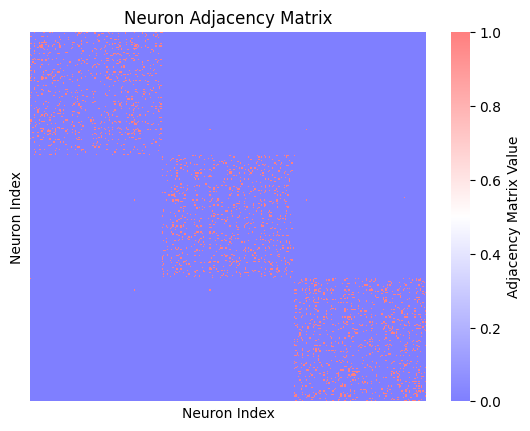



Network Configuration:


KeyboardInterrupt: 

In [5]:
# Define the positions array
pos_array = GeneratePosArray(
        implement_nueron_modules_positions,
        n_dim = n_dim,
        radius = radius,
        n = n,
        num_groups = num_groups,
        n_per_group = n_per_group,
        seed = seed,
        std = module_std,
        x1_mean = x1_mean, 
        x2_mean = x2_mean,
        x3_mean = x3_mean,
        y1_mean = y1_mean,
        y2_mean = y2_mean,
        y3_mean = y3_mean, 
)

n = pos_array.shape[0]

# Calculate the euclidean distance between all nodes
distance_matrix = GetDistanceMatrix(
    pos_array = pos_array,
    n_dim = n_dim,
    check_symmetry = check_distance_matrix_symmetry
)

# Define the adjacency matrix and edges of the network
A, edges, rich_club_neurons = GetAdjacencyMatrix(
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    distance_matrix = distance_matrix,
    pos_array = pos_array,
    radius = radius,
    n_dim = n_dim,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    n_per_group = n_per_group,
    num_groups = num_groups,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant_for_modules,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability
)

# The logic from inside of the FullSimulation code, just need it in Global Space for this portion
if implement_timing:
    # Find axons that should be myelinated if constant diameter
    myelinated_index = np.zeros(edges.shape[0])

    # Myelinated the signals between modules
    if implement_neuron_modules_connections:
        mod_1_to_2 = np.argwhere(np.logical_and(edges[:,0] == 0, edges[:, 1] == n_per_group)).flatten()
        mod_2_to_3 = np.argwhere(np.logical_and(edges[:,0] == n_per_group, edges[:, 1] == n_per_group*2)).flatten()
        mode_3_to_2 = np.argwhere(np.logical_and(edges[:,0] == n_per_group*3, edges[:, 1] == 0)).flatten()

        myelinated_index[mod_1_to_2] = 1
        myelinated_index[mod_2_to_3] = 1
        myelinated_index[mode_3_to_2] = 1
    
    time_to_complete_ap = PosArray_to_SignalTiming(
        pos_array, edges, config_dict, 
        constant_diameter, myelinated_index
    )
else:
    time_to_complete_ap = None

if implement_constant_weights:
    weight_adjustement = np.ones((n,n)) * constant_weight_value
    
else:
    weight_adjustement = np.random.normal(loc = mean_weight_val, scale = std_weight_val, size = (n,n))

    if weight_rich_club_connections_more:
        module_linking_neurons = np.array([0, n_per_group, n_per_group*2])
        weight_adjustement[module_linking_neurons, :] /= weight_adjustement[module_linking_neurons, :] # Set these all to 1 so that they have the maximum weight

In [ ]:
# This data below was created in the execution-of-neural-simulation notebook

In [ ]:
# Define the number of time series to create
num_samples = 10
np.random.seed(seed) # Set the seed on the outside to have reproducible results
for experiment_id in range(num_samples):
    print(f'Current Experiment ID: {experiment_id}')
    constant_injected_current_index  = np.random.choice(
        np.arange(n), num_neurons_to_stimluate, 
        replace = False
    )
    out = SimulateNeurons(
        pos_array = pos_array,
        edges = edges,
        weights = A * weight_adjustement,
        num_time_steps = num_time_steps,
        time_to_complete_ap = time_to_complete_ap,
        q = q, # Random process added in
        constant_injected_current_index = constant_injected_current_index,
        vary_neuron_type = vary_neuron_type,
        resting_voltage = resting_voltage,
        default_a = default_a,
        default_b = default_b,
        default_c = default_c,
        default_d = default_d,
        superthreshold_injected_current = superthreshold_injected_current,
        highest_injected_current = highest_injected_current_for_modules,
        t_step_size = t_step_size,
        injected_current_decay_parameter = injected_current_decay_parameter,
        diagnostic_printing = diagnostic_printing,
        num_time_steps_with_injection = num_time_steps_with_injection
    )
    
    # Save the data
    np.savetxt(base_path + f'voltages/voltages-experiment-id-{experiment_id}.csv', out.voltages, delimiter = ',') # Voltages
    np.savetxt(base_path + f'spikes/spikes-experiment-id-{experiment_id}.csv', out.spikes, delimiter = ',') # Spikes
    np.savetxt(base_path + f'injected-current/injected-current-experiment-id-{experiment_id}.csv', out.injected_current, delimiter = ',') # Injected current
    np.savetxt(base_path + f'input-neurons/input-neurons-experiment-id-{experiment_id}.csv', constant_injected_current_index, delimiter = ',') # Input to the system, i.e. the neurons being stimulated

In [3]:
# Need a way to get the NamedTuple back
def CreateNamedTuple(
    voltages,
    t_step_size, # Make sure in ms
    num_time_steps
):
    SimulationResults = namedtuple(
        'SimulationResults', 
        [
            'voltages', 'us', 'injected_current',
            'spikes', 'q', 'num_time_steps', 't_step_size',
            't_index'
        ]
    )

    out = SimulationResults(
        voltages = voltages,
        us = None,
        injected_current = None,
        spikes = None,
        q = None,
        num_time_steps = num_time_steps,
        t_step_size = t_step_size,
        t_index = None
    )

    return out
    

In [8]:
# Load in the data to see what it looks like and create the low dimensional data
voltages = []
input_neurons = []
pca_decompositions = []
eig_vecs = []
num_dim_pca = 2 # Going to keep it with how it was above

plot_trajectories = False
t_step_size = float(config_dict['timing']['t_step_size']) * 1000 # setting it to ms

num_samples = 10

base_path = 'experiments/'

for experiment_id in range(num_samples):
    print(f'Experiment ID: {experiment_id}')
    
    # Load in voltages and input neurons
    voltage_i = np.loadtxt(base_path + f'voltages/voltages-experiment-id-{experiment_id}.csv', delimiter = ',')
    inputs_i = np.loadtxt(base_path + f'input-neurons/input-neurons-experiment-id-{experiment_id}.csv', delimiter = ',')

    # Create the out object
    out = CreateNamedTuple(
        voltage_i, t_step_size, 
        num_time_steps
    )
    
    # Plot the voltage traces
    # voltage_fig_path = base_path + f'figures/voltage-trace-experiment-id-{experiment_id}.png'
    # PlotVoltageTrace(
    #     out, flip_axes=True, 
    #     include_node_indices=False, cmap = 'grey_r', 
    #     save_graphic_path=voltage_fig_path
    # )  

    # Commenting these out so that I calculate the shared PCA rather than the unique
    # Gather the PCA decomposition
    x_reduced, eig, eig_vecs_i = PCA(out, num_dim_pca, gaussian_filter_sigma, on_derivative = False)

    # Plot the PCA Over Time
    # pca_trajectory_path = base_path + f'figures/pca-trajectory-non-derivatives-experiment-id-{experiment_id}.png'
    # if plot_trajectories:
    #     PCATrajectoryOverTime(x_reduced, num_time_steps, pca_trajectory_path)
    
    # Save in global space
    voltages += [voltage_i]
    # input_neurons += [inputs_i]
    pca_decompositions += [x_reduced]
    eig_vecs += [eig_vecs_i]
    

Experiment ID: 0
Experiment ID: 1
Experiment ID: 2
Experiment ID: 3
Experiment ID: 4
Experiment ID: 5
Experiment ID: 6
Experiment ID: 7
Experiment ID: 8
Experiment ID: 9


#### Fitting the Actual Model

In [5]:
# Analysis
import pysindy as ps

# For cross validation and splitting the time series
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
### Not Sure if I need this, maybe the starting point helps with it
# Getting the lower dimensional input vectors to the network
input_vectors = []

for experiment_id in range(num_samples):
    # Define an input matrix
    input_mat = np.zeros((num_time_steps, n))

    # Fill in the values that were there
    idx = input_neurons[experiment_id].astype(np.int64)
    input_mat[:, idx] = 1 # Indicate that they were stimulated

    # Project into lower dimension using the principle components of the system
    input_mat = input_mat @ eig_vecs[experiment_id][:, :num_dim_pca] 

    input_vectors += [input_mat]

IndexError: list index out of range

In [12]:
# Define differntiation method
differentiation_method = ps.SmoothedFiniteDifference(order=2)

# Define candidate library
feature_library = ps.PolynomialLibrary(degree=3) + ps.FourierLibrary(n_frequencies=3)

# Define an optimizer
optimizer = ps.STLSQ(threshold=0.005)

# Create a model object
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
)

# Create a k-fold cross validation object
kf = KFold(n_splits=8, shuffle=True, random_state=2302)

testing_errors = []

trajectory_paths = 'experiments/figures/model-predictions/'

training_loop_indicator = 0
for train_idx, test_idx in kf.split(pca_decompositions):
    print(f'Fold: {training_loop_indicator}') # Keeping track of what fold I'm on
    training_loop_indicator += 1
    # Combine trajectories for training
    pca_train_list = [pca_decompositions[i] for i in train_idx]
    # input_train_list = [input_vectors[i] for i in train_idx]
    
    pca_test_list = [pca_decompositions[i] for i in test_idx]
    # input_test_list = [input_vectors[i] for i in test_idx]
    
    # Fit SINDy
    model.fit(pca_train_list, t=t_step_size, feature_names=["PC1", "PC2"])
    
    # Evaluate each test trajectory
    for i, pca_test in enumerate(pca_test_list):
        initial_condition = pca_test_list[i][0] 
        
        # simulate SINDy model
        pred = model.simulate(initial_condition, t = np.arange(num_time_steps))

        # Plotting the predictions
        plt.plot(pca_test_list[i][:, 0], pca_test_list[i][:, 1], label = 'True', color = 'b')
        plt.plot(pred[:, 0], pred[:, 1], label = 'Predicted', color = 'r')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        plt.savefig(trajectory_paths + f'true-vs-model-trajectory-id-{test_idx[i]}-fold-{training_loop_indicator}.png')
        plt.clf()

        # Save the trace for later use
        np.savetxt(trajectory_paths + f'predicted-trajectory-test-id-{test_idx[i]}-fold-training_loop_indicator.csv', pred, delimiter = ',')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Average Testing Error Across: nan


/usr/local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning:

invalid value encountered in scalar divide



<Figure size 640x480 with 0 Axes>

### Updated Code to Deal with Keeping Same Trajectories

In [58]:
for train_idx, test_idx in kf.split(pca_decompositions):
    print(test_idx, '\n')

[8 9] 

[0 1] 

[6] 

[4] 

[7] 

[3] 

[2] 

[5] 



Fold: 0


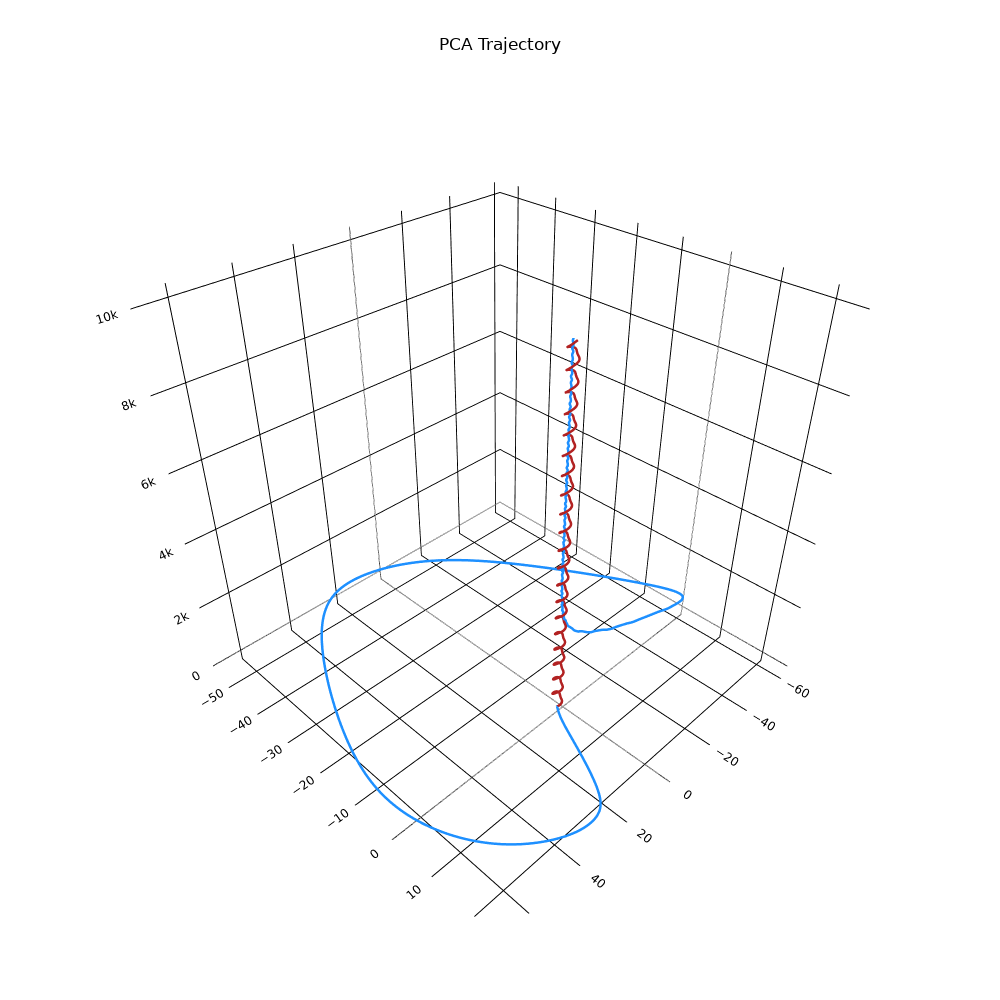

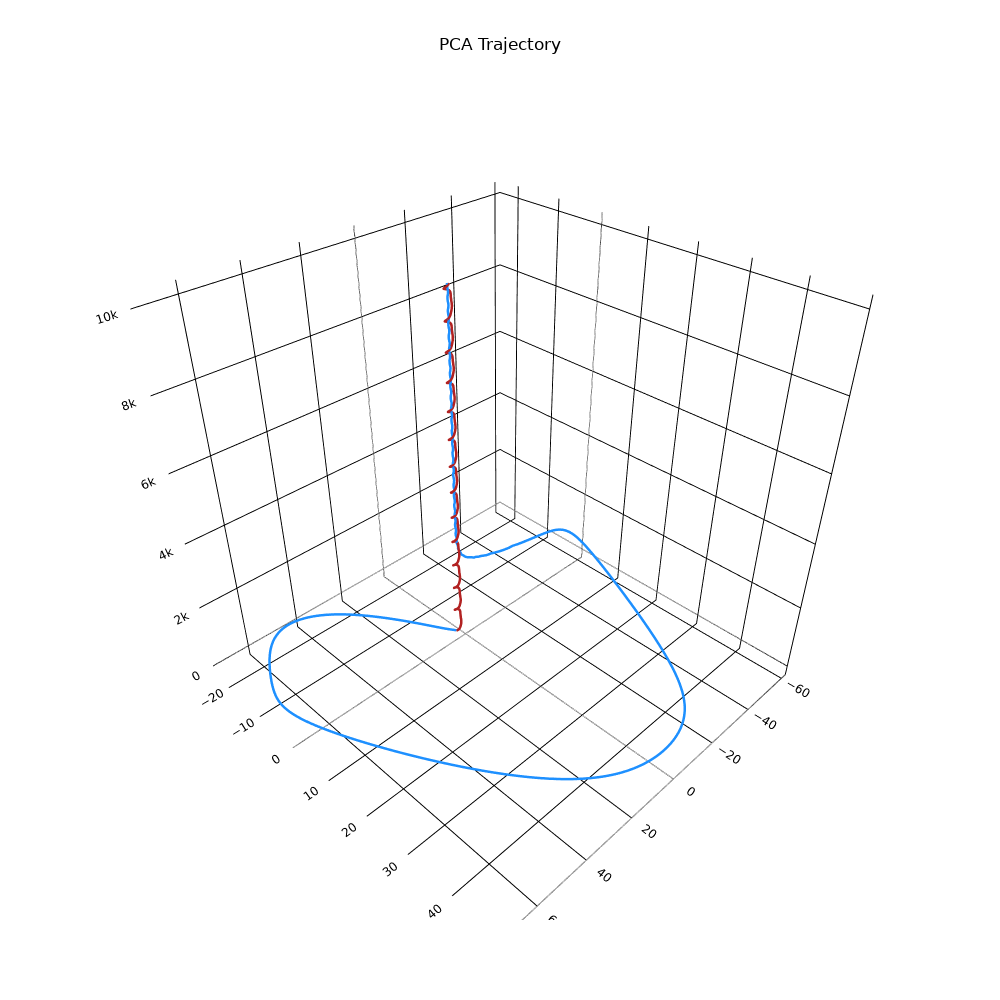

Fold: 1


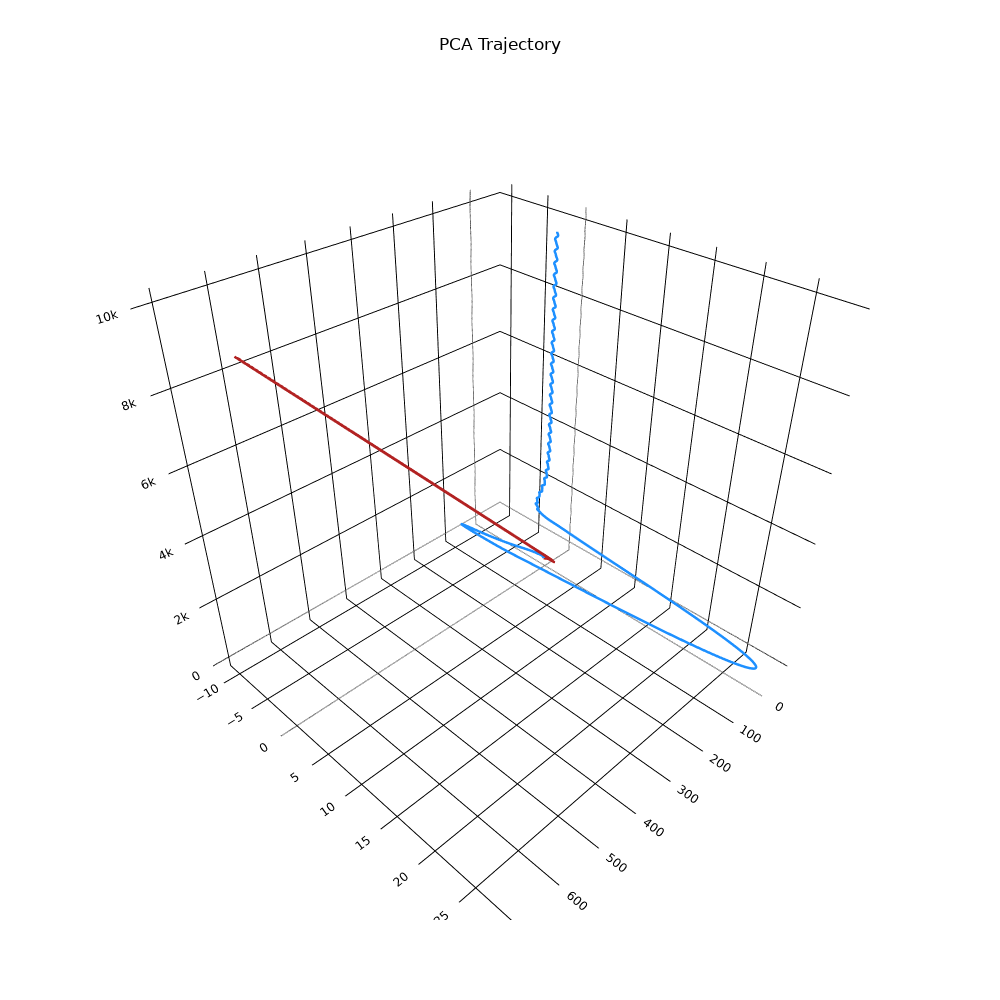

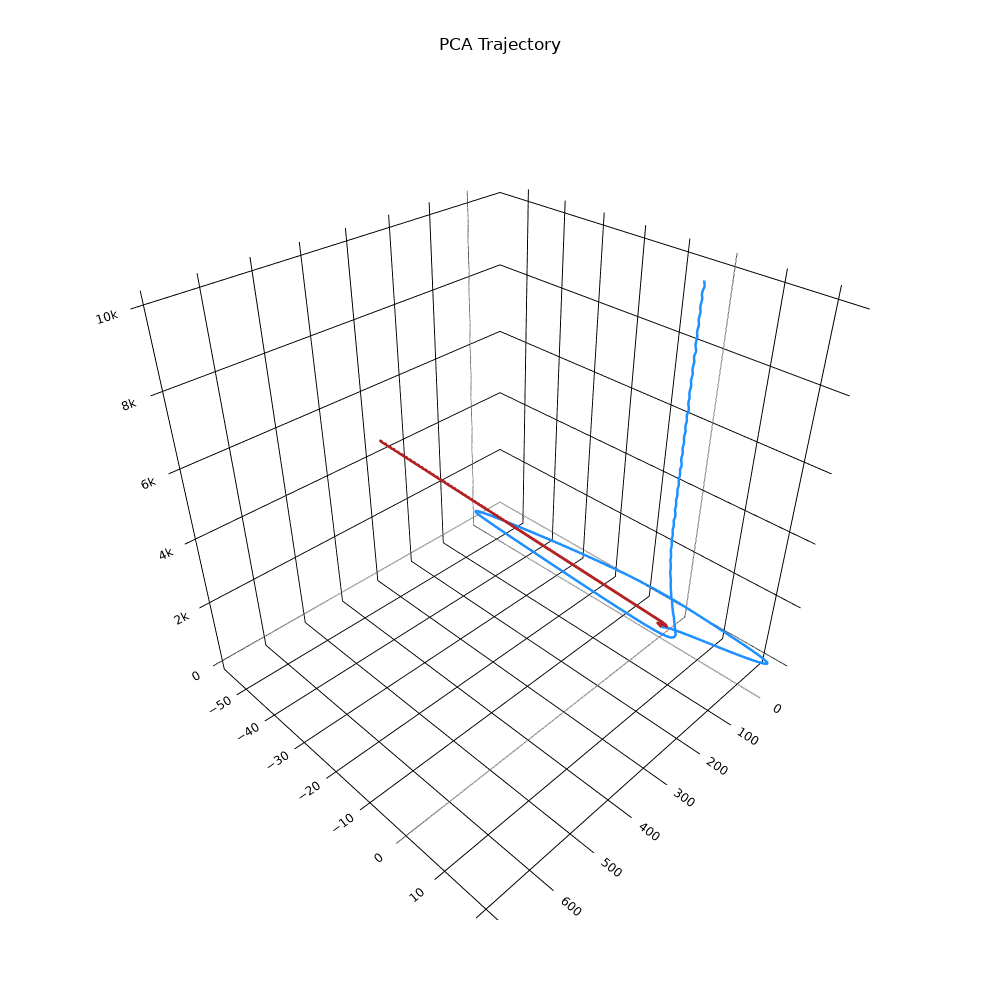

Fold: 2


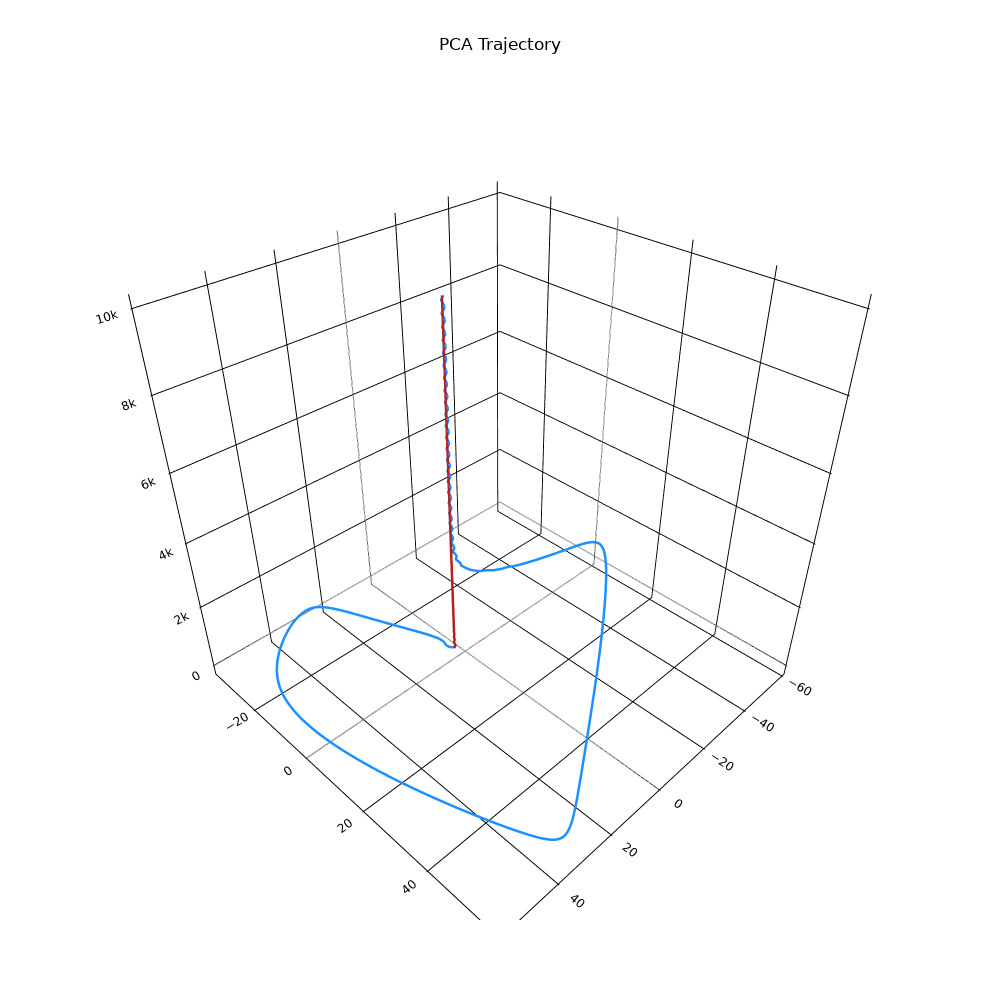

Fold: 3


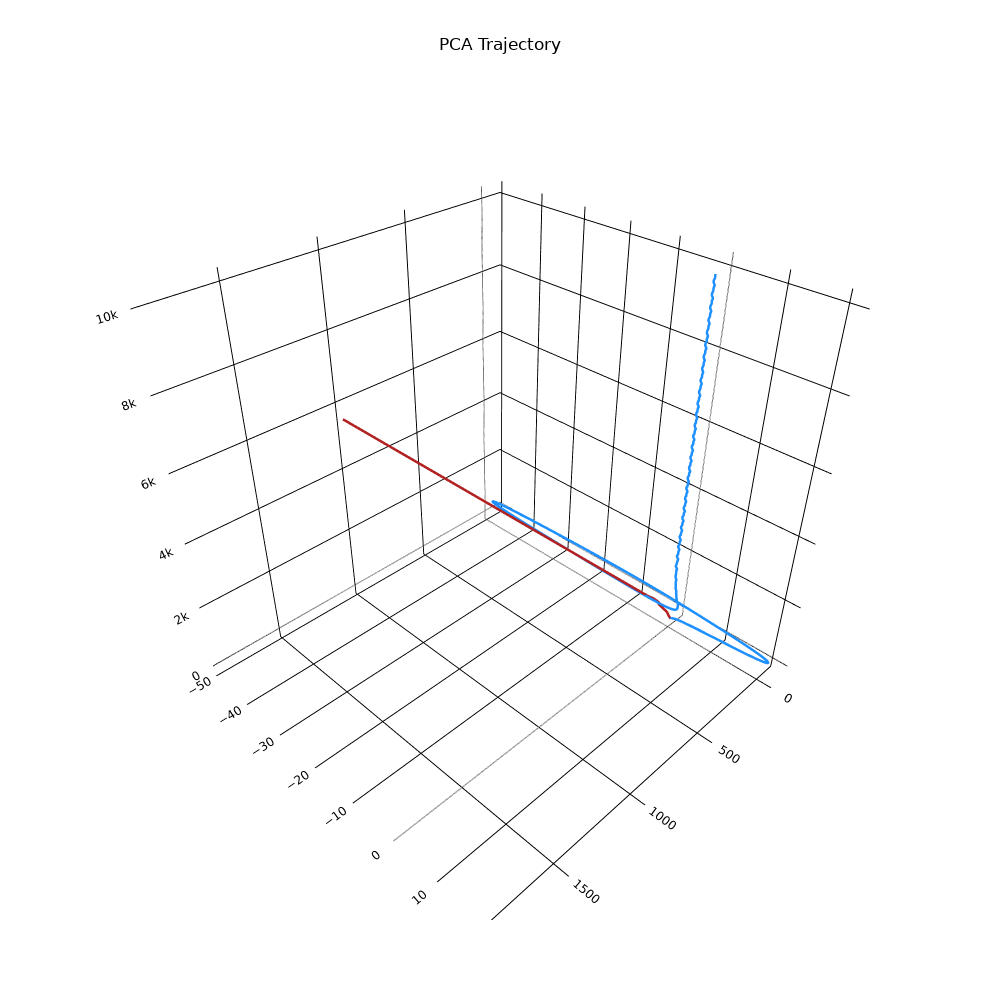

Fold: 4


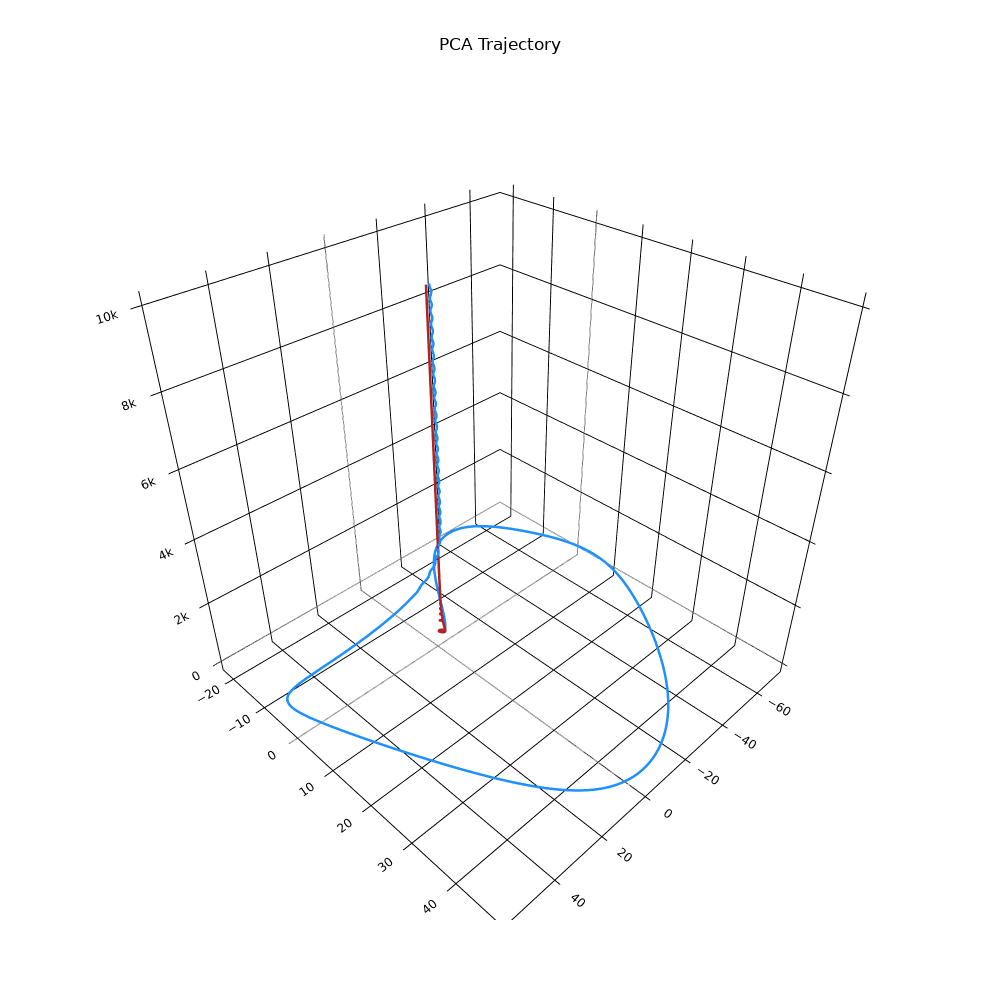

Fold: 5


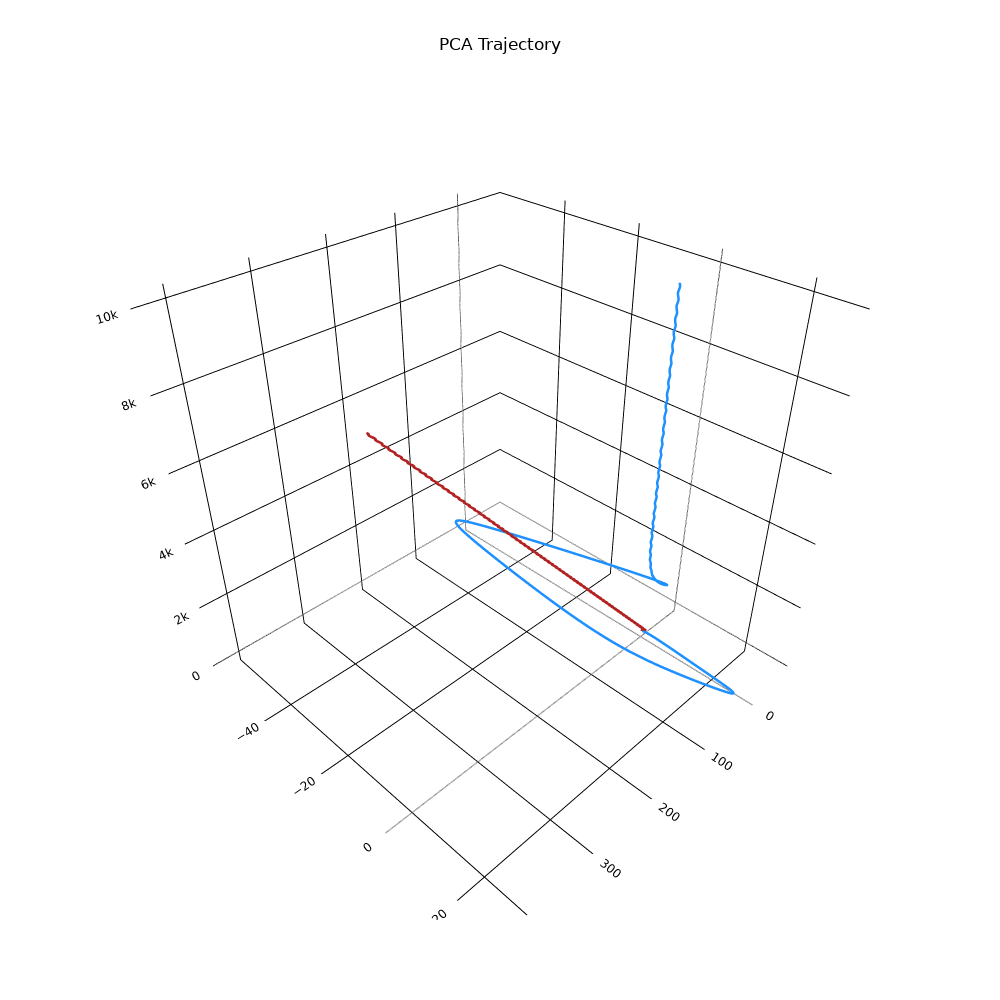

Fold: 6


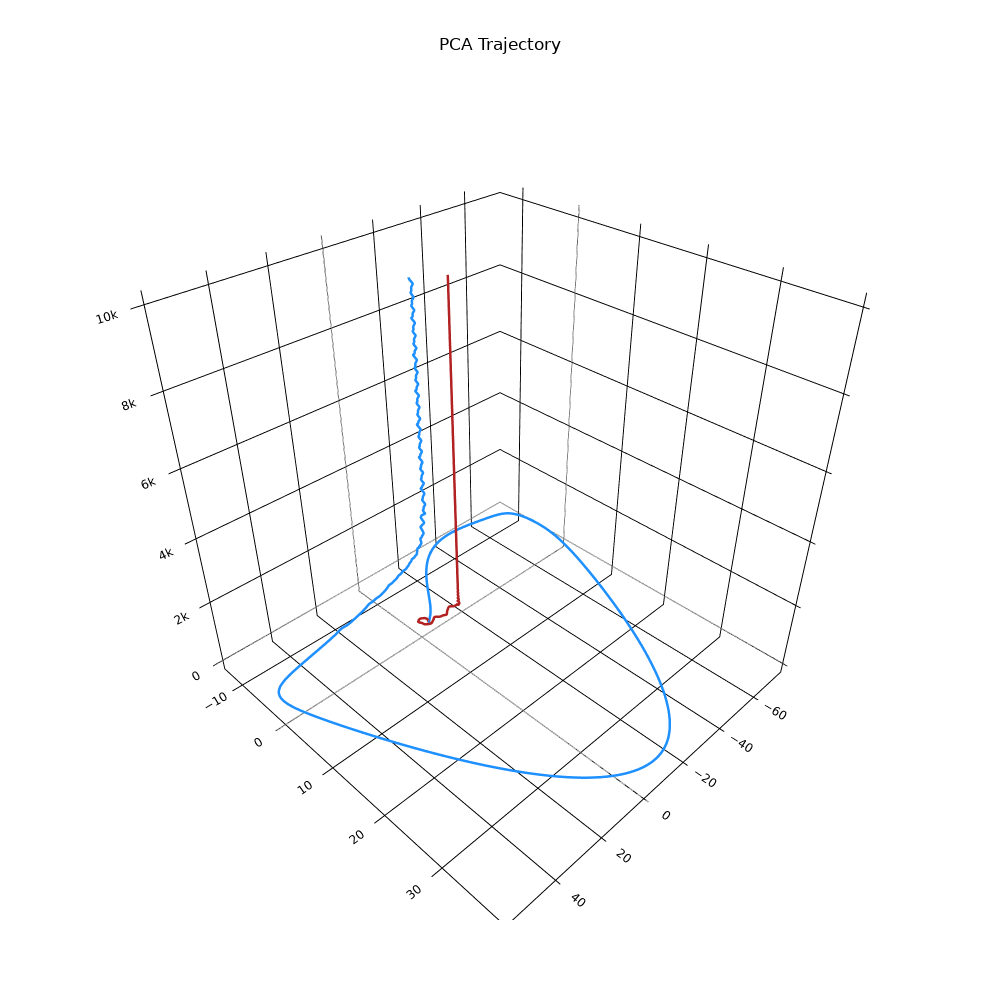

Fold: 7


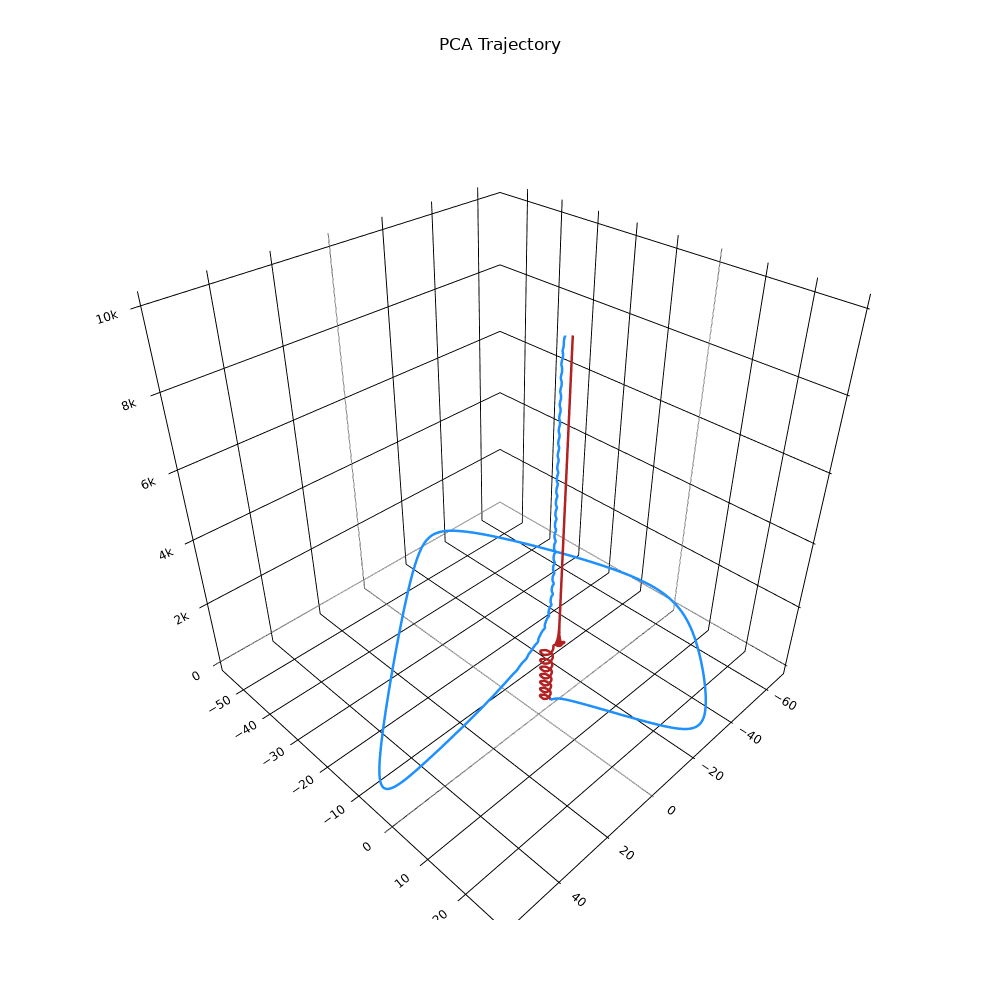

In [57]:
# Define differntiation method
differentiation_method = ps.SmoothedFiniteDifference(order=2)

# Define candidate library
feature_library = ps.PolynomialLibrary(degree=3) + ps.FourierLibrary(n_frequencies=3)

# Define an optimizer
optimizer = ps.STLSQ(threshold=0.005)

# Create a model object
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
)

# Create a k-fold cross validation object
kf = KFold(n_splits=8, shuffle=True, random_state=2302)

testing_errors = []

trajectory_paths = 'experiments/figures/updated-model-predictions/'

training_loop_indicator = 0
for train_idx, test_idx in kf.split(pca_decompositions):
    print(f'Fold: {training_loop_indicator}') # Keeping track of what fold I'm on
    training_loop_indicator += 1
    # Combine trajectories for training
    pca_train_list = [pca_decompositions[i] for i in train_idx]
    # input_train_list = [input_vectors[i] for i in train_idx]
    
    pca_test_list = [pca_decompositions[i] for i in test_idx]
    # input_test_list = [input_vectors[i] for i in test_idx]
    
    # Fit SINDy
    model.fit(pca_train_list, t=t_step_size, feature_names=["PC1", "PC2"])
    
    # Evaluate each test trajectory
    for i, pca_test in enumerate(pca_test_list):
        initial_condition = pca_test_list[i][0] 
        
        # simulate SINDy model
        pred = model.simulate(initial_condition, t = np.arange(num_time_steps))

        # Plotting the predictions
        # plt.plot(pca_test_list[i][:, 0], pca_test_list[i][:, 1], label = 'True', color = 'b')
        # plt.plot(pred[:, 0], pred[:, 1], label = 'Predicted', color = 'r')
        # plt.xlabel('PC1')
        # plt.ylabel('PC2')
        # plt.legend()
        # plt.savefig()
        # plt.clf()

        PCATrajectoryOverTimeforModel(
            pca_test_list[i],
            pred,
            num_time_steps,
            save_filepath = trajectory_paths + f'true-vs-model-trajectory-id-{test_idx[i]}-fold-{training_loop_indicator}.png'
        )

        # Save the trace for later use
        np.savetxt(trajectory_paths + f'predicted-trajectory-test-id-{test_idx[i]}-fold-training_loop_indicator.csv', pred, delimiter = ',')

#### Fitting on the entire data set

In [10]:
# Fit on the whole data set
# Define differntiation method
differentiation_method = ps.SmoothedFiniteDifference(order=2)

# Define candidate library
feature_library = ps.PolynomialLibrary(degree=3) + ps.FourierLibrary(n_frequencies=3)

# Define an optimizer
optimizer = ps.STLSQ(threshold=0.005)

# Create a model object
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
)

# Fit SINDy
model.fit(pca_decompositions, t=t_step_size, feature_names=["PC1", "PC2"])

,optimizer,STLSQ(threshold=0.005)
,feature_library,ConcatLibrary...equencies=3)])
,differentiation_method,SmoothedFiniteDifference()
,discrete_time,False
,libraries,"[PolynomialLibrary(degree=3), FourierLibrar...frequencies=3)]"
,threshold,0.005
,alpha,0.05
,max_iter,20
,ridge_kw,None
,normalize_columns,False
,copy_X,True


0


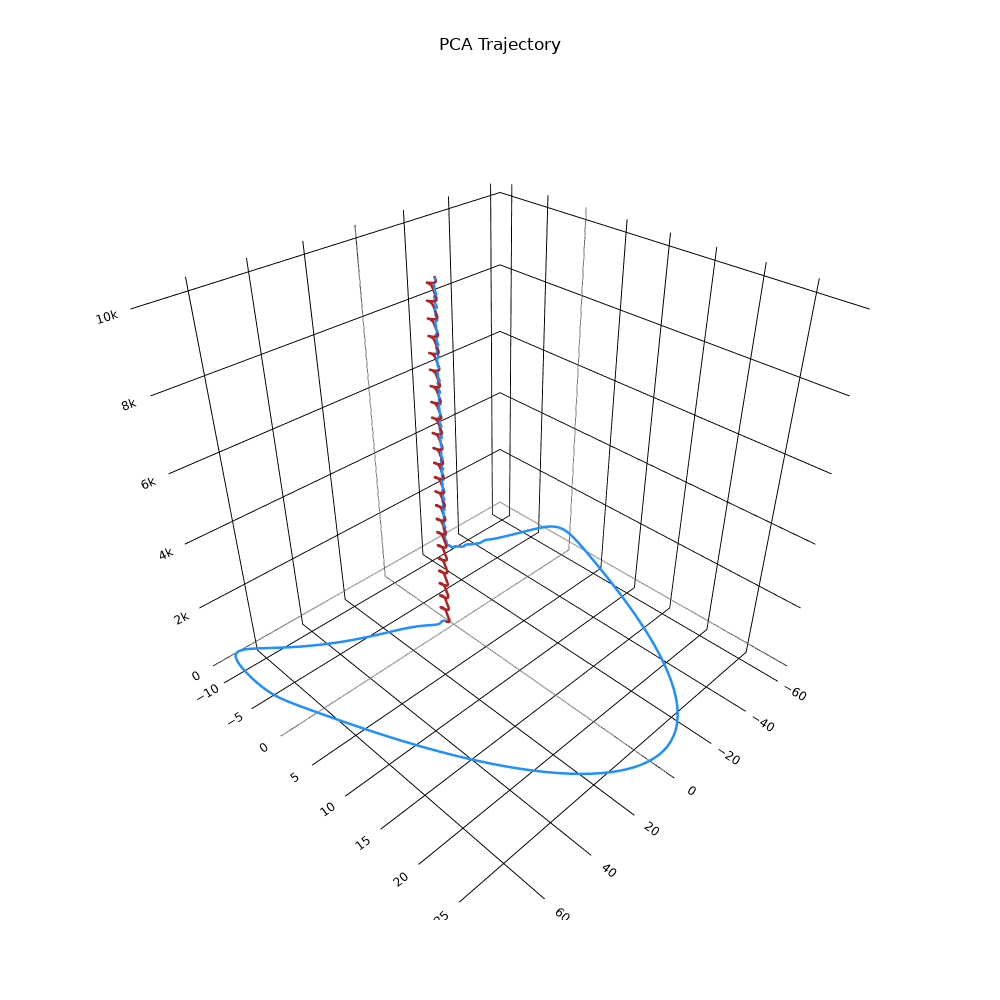

1


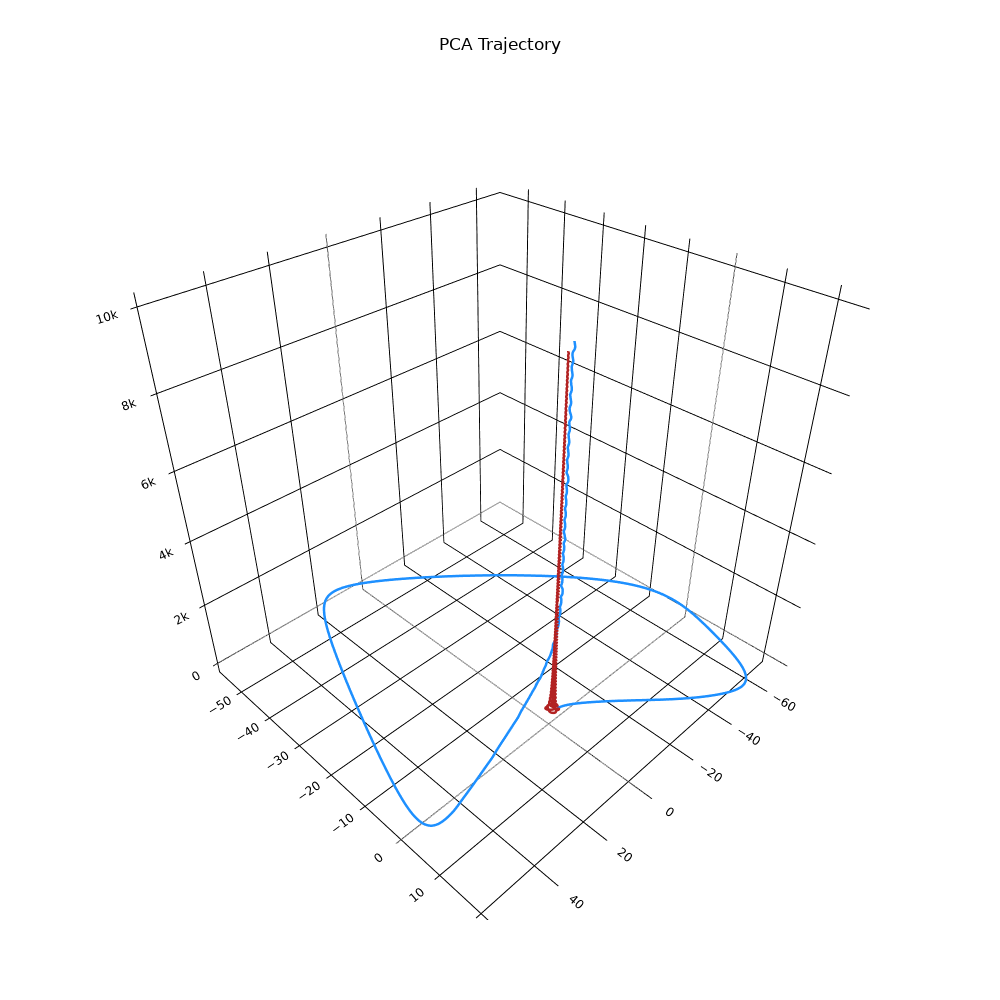

2


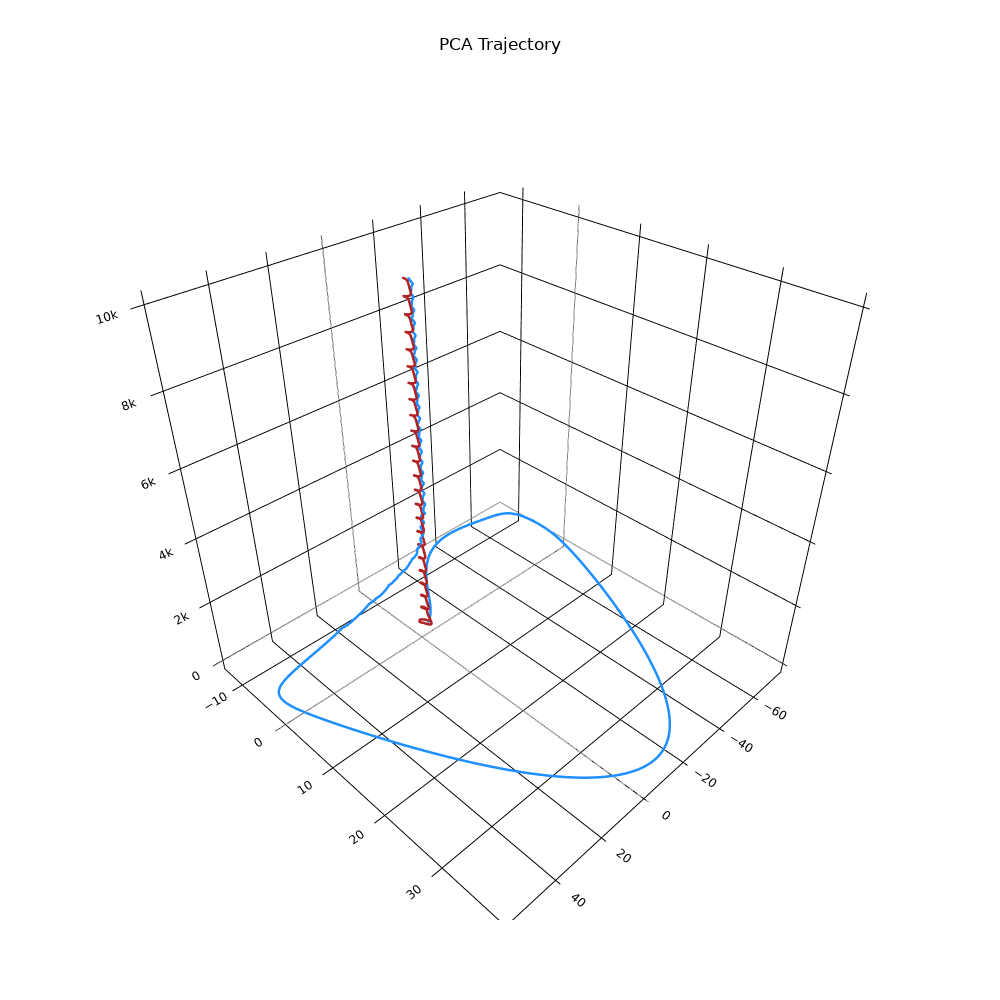

3


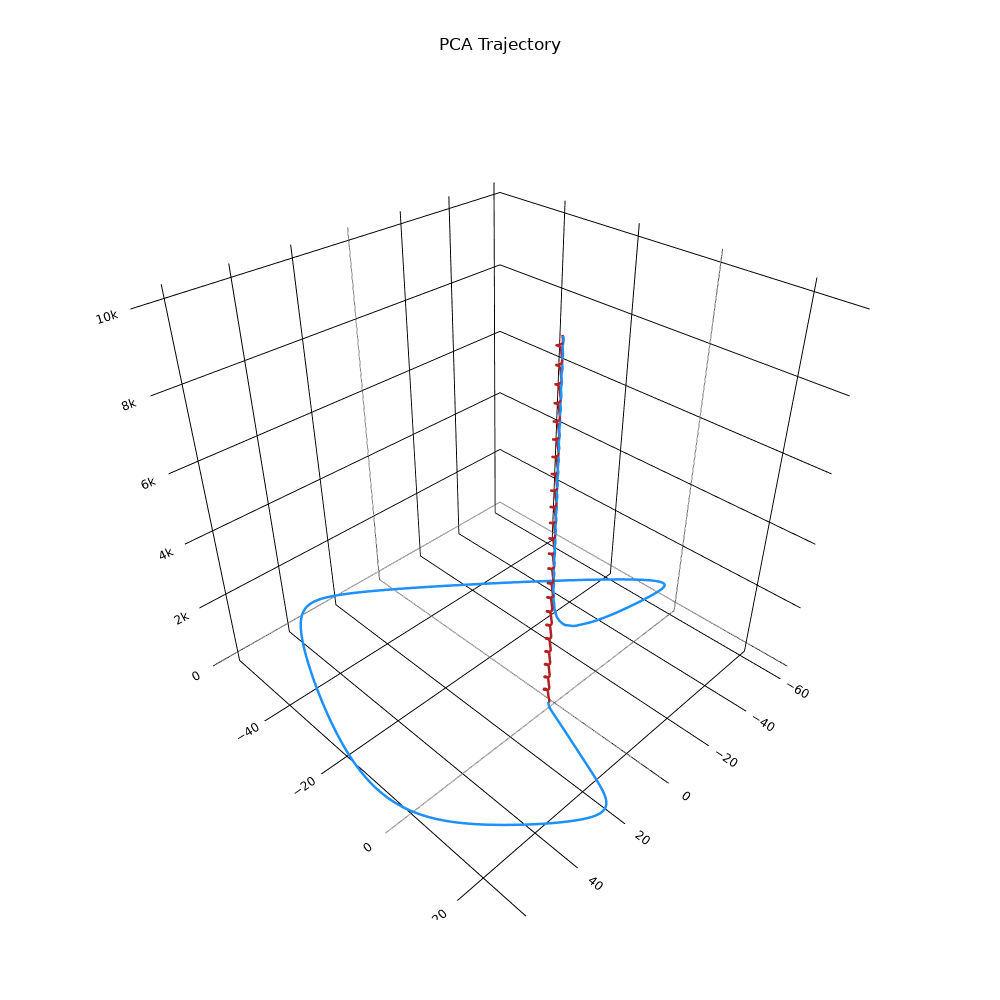

4


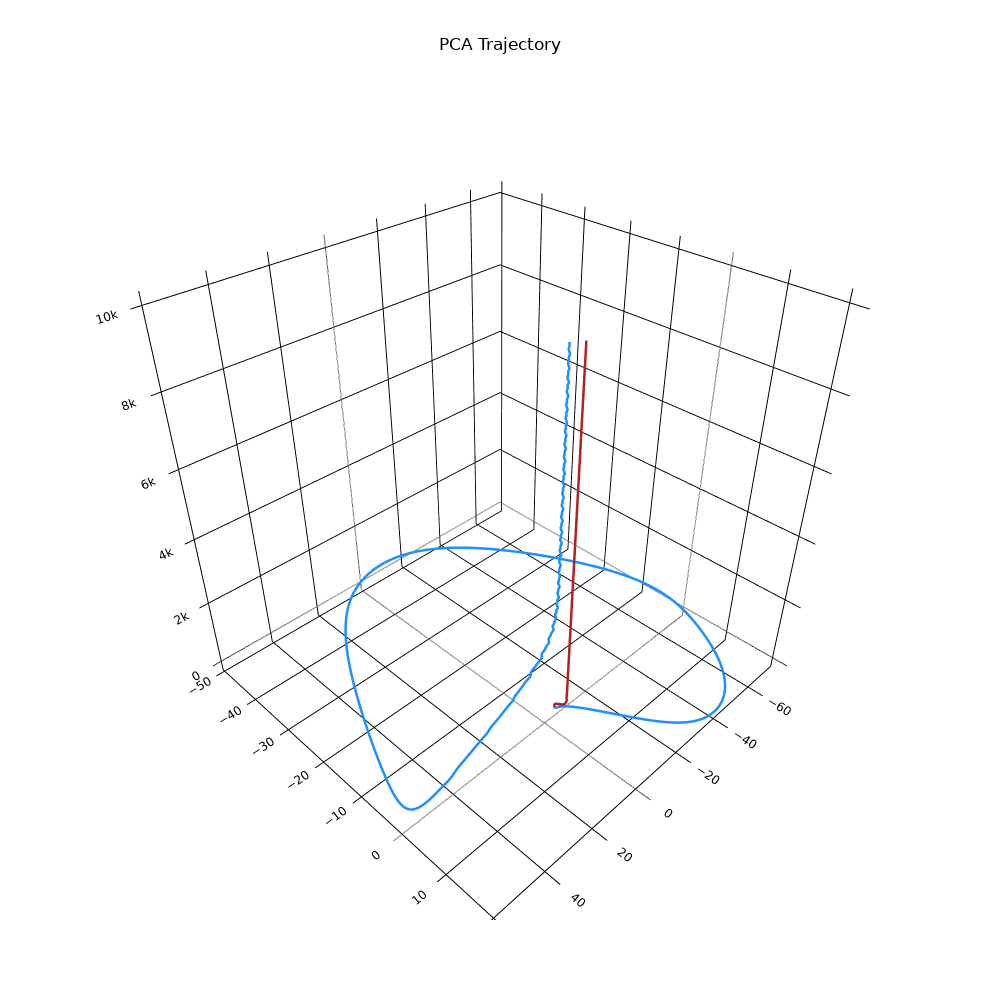

5


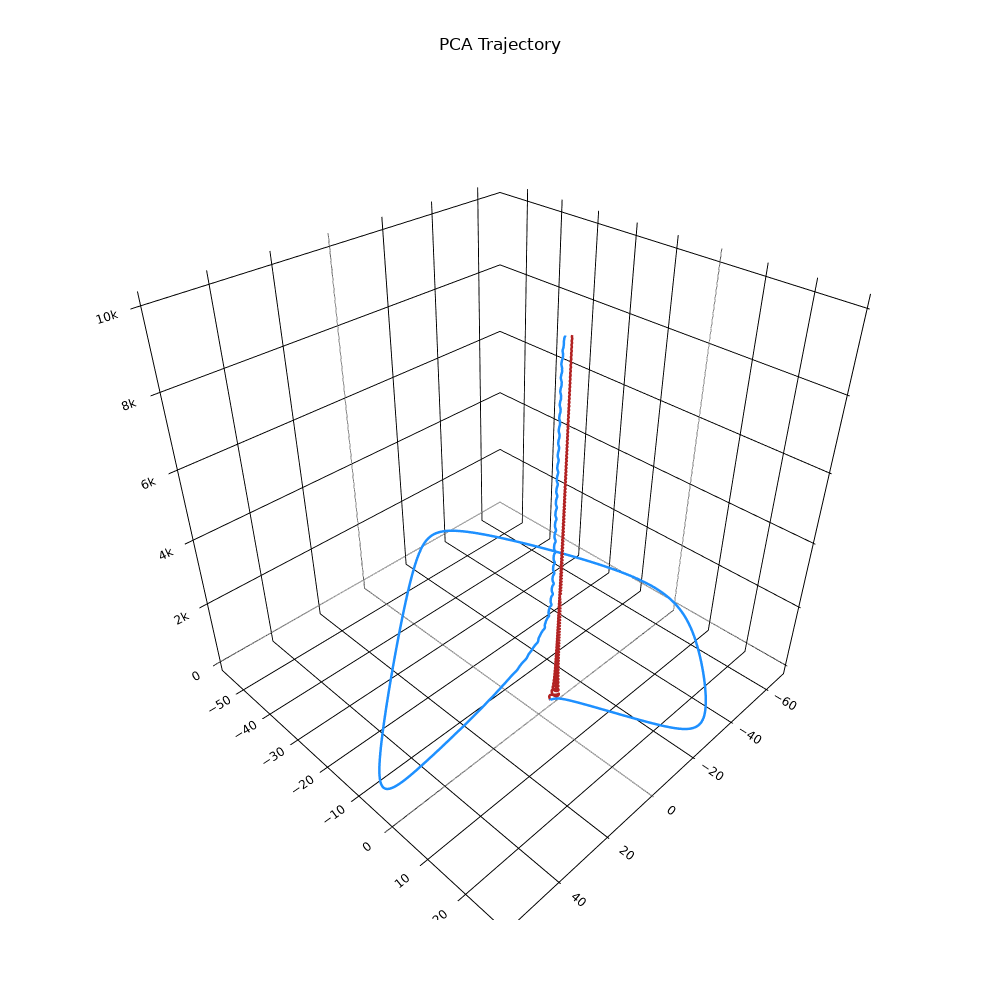

6


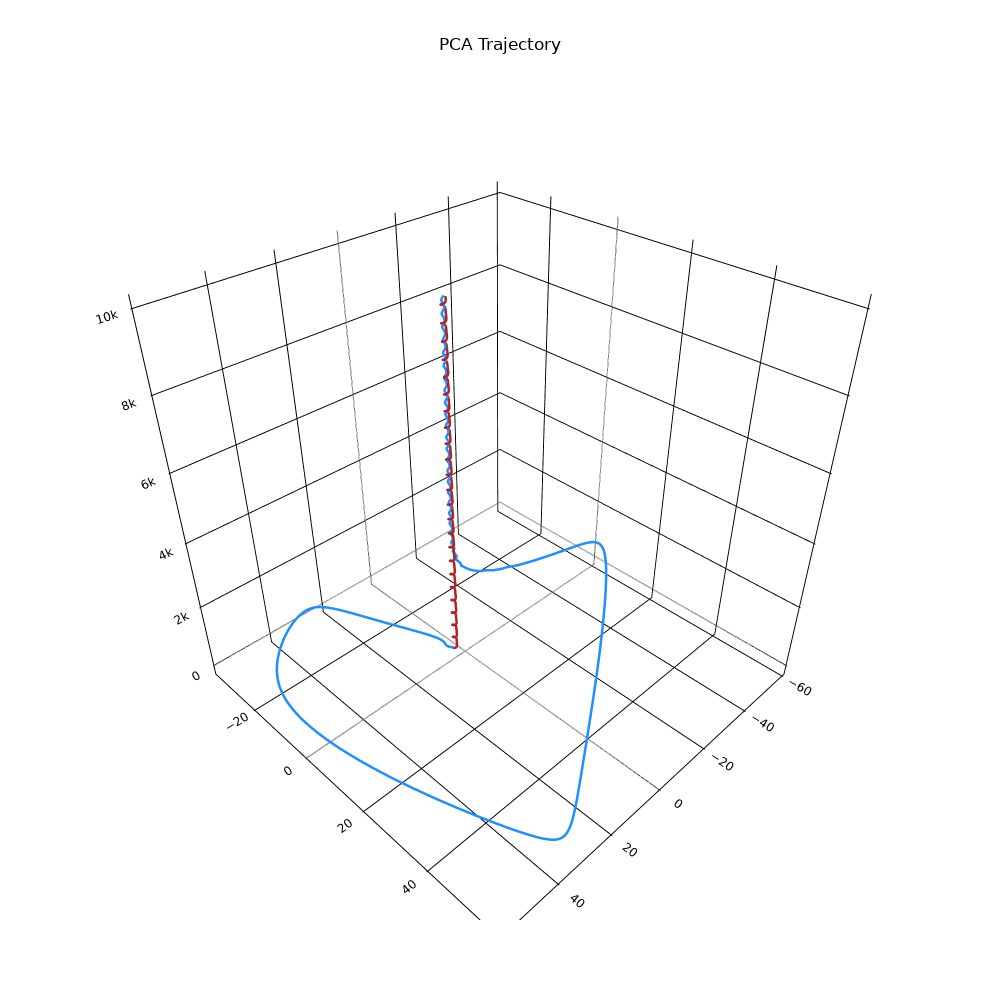

7


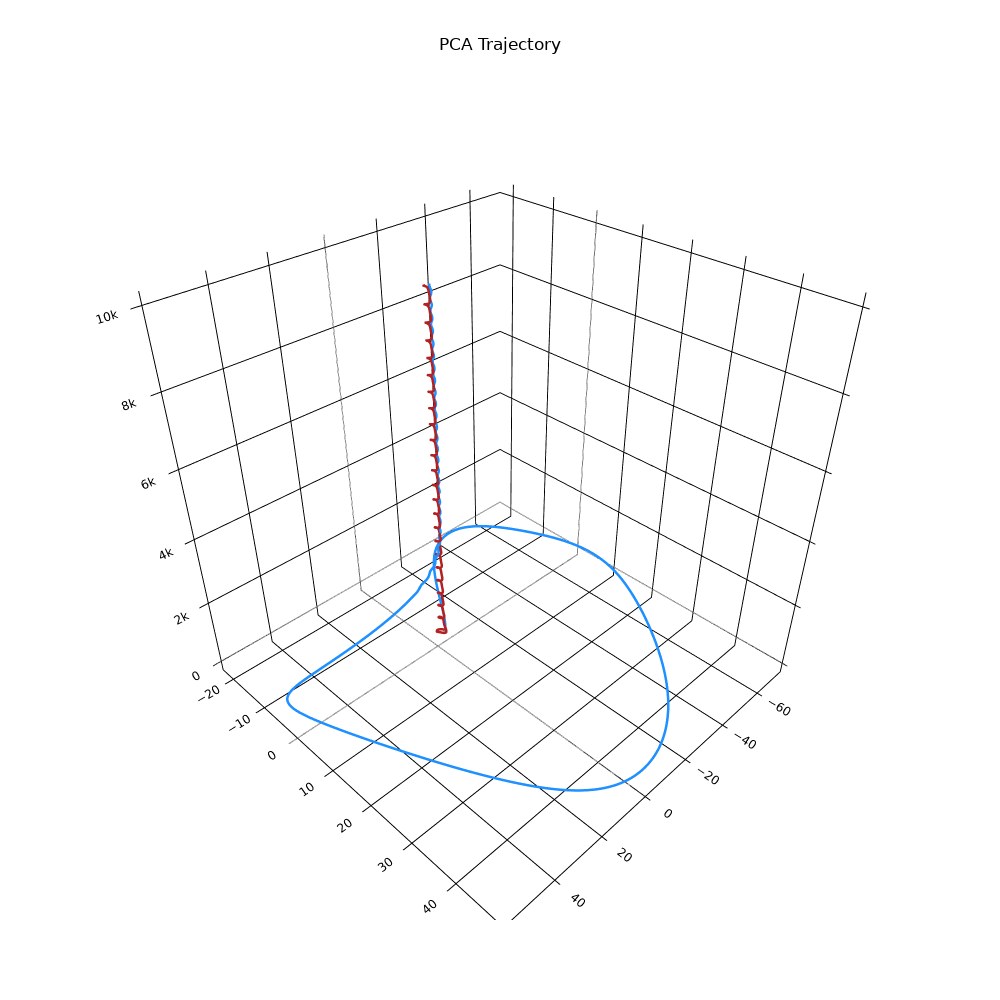

8


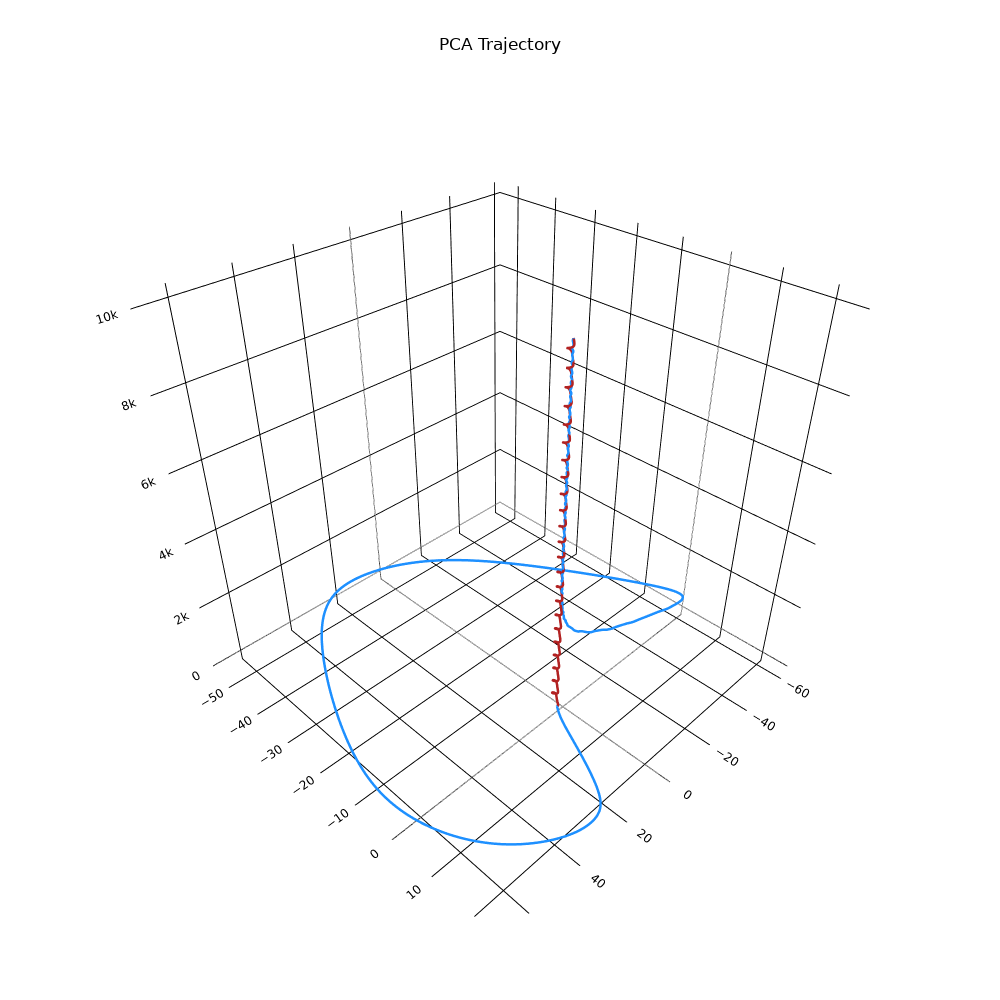

9


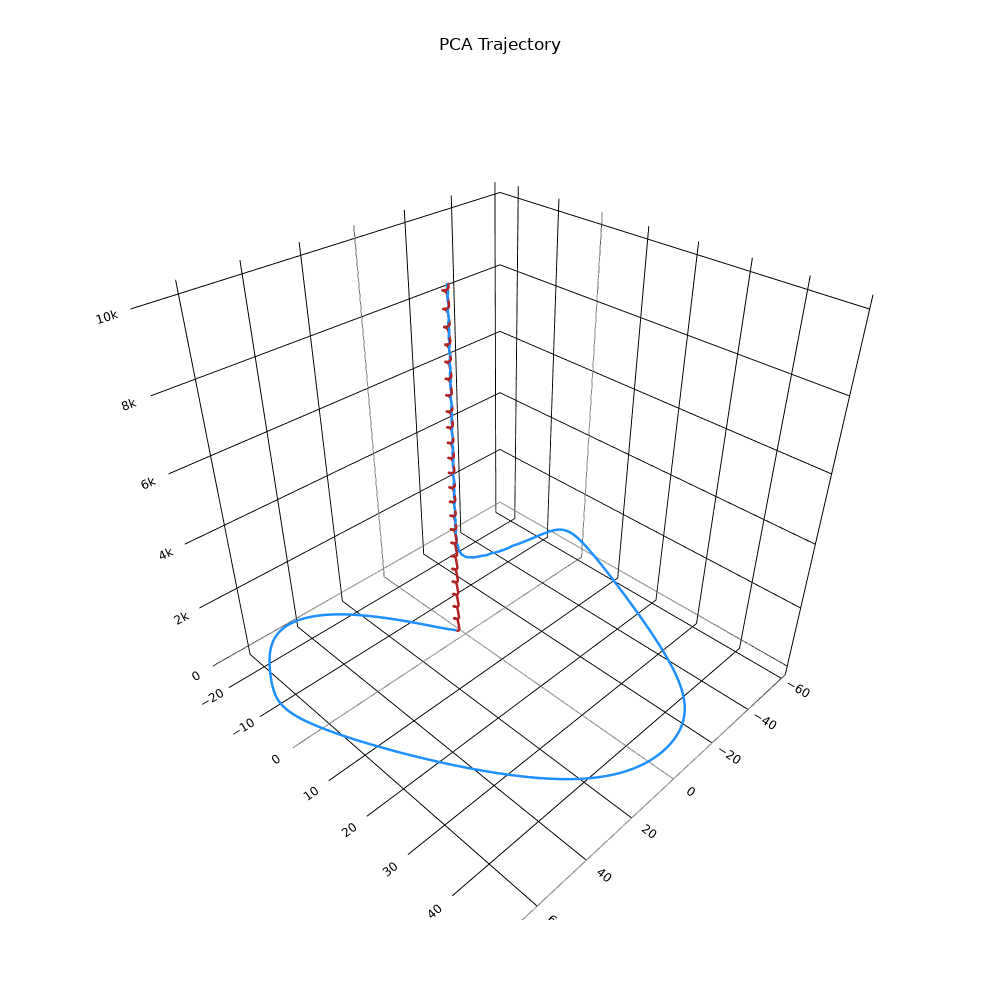

In [34]:
predicted_trajectories = []

# View how the method worked
for i, trajectory in enumerate(pca_decompositions):
    print(f'{i}')

    initial_condition = trajectory[0]

    pred = model.simulate(initial_condition, t = np.arange(num_time_steps))

    PCATrajectoryOverTimeforModel(
        trajectory,
        pred,
        num_time_steps,
        save_filepath = f'experiments/figures/updated-model-predictions/trajectory-{i}.png'
    )

    predicted_trajectories += [pred]

In [52]:
# Plot the residuals over time
for i in range(num_samples):
    trajectory = pca_decompositions[i]
    pred = predicted_trajectories[i]

    # Find euclidean distance between the two
    residual = np.linalg.norm(trajectory - pred, axis = 1)
    ts = np.arange(num_time_steps * t_step_size, step = t_step_size)
    
    plt.plot(ts, residual, color = 'firebrick')
    plt.xlabel('Time (ms)')
    plt.ylabel('Residual')
    plt.title(f'Error Over Time: Trajectory {i}')
    plt.axhline(y = 0, linestyle = '--', color = 'black', alpha = 0.2)
    plt.savefig(f'experiments/figures/updated-model-predictions/residuals-over-time-trajectory-{i}.png')

    plt.clf()

<Figure size 640x480 with 0 Axes>

In [32]:
# Comparing the two trajectories
def PCATrajectoryOverTimeforModel(
    true_trajectory,
    predicted_trajectory,
    num_time_steps,
    save_filepath = None
):
    
    t = np.arange(num_time_steps) # * t_step_size * 1000)
    plot_data = go.Scatter3d(
        x=true_trajectory[:, 0],
        y=true_trajectory[:, 1],
        z=t, # x_reduced[:, 2],
        mode='lines',
        line=dict(
            color='dodgerblue',         # color represents time
            # colorscale='Viridis',
            width=5
        )
    )

    predicted_data = go.Scatter3d(
        x=predicted_trajectory[:, 0],
        y=predicted_trajectory[:, 1],
        z=t, # x_reduced[:, 2],
        mode='lines',
        line=dict(
            color='firebrick',         # color represents time
            # colorscale='Plasma',
            width=5
        )
    )
    
    axis = dict(
        showbackground=True,
        showline=True,
        zeroline=True,
        showgrid=True,
        showticklabels=True,
        title='',
        backgroundcolor = '#FFFFFF',
        gridcolor = 'black',
        gridwidth = 2,
        # range=[-axis_limit, axis_limit]
    )
    
    scene = dict(
        xaxis=dict(axis),
        yaxis=dict(axis),
        zaxis=dict(axis)
    )
    
    layout = go.Layout(
        title={
            'text': 'PCA Trajectory',
            'x': 0.5
        },
        xaxis_title='PC1',
        yaxis_title='PC2',
        width=1000,
        height=1000,
        showlegend=False,
        scene=scene,
         margin=dict(
            t=100
        ),
        hovermode='closest',
        font = {
            'family': 'Arial',
            'color': 'black',
            'size': 12
        }
    )
    
    fig = go.Figure(
        data = [plot_data, predicted_data],
        layout = layout
    )

    if save_filepath is not None:
        fig.write_image(save_filepath)
        fig.show(renderer="png")
        # return fig
    else:
        # return fig
        fig.show(renderer="png")

#### Comparing residuals for K-fold cross validation

In [59]:
import glob

trajectory_paths = 'experiments/figures/updated-model-predictions/'

# Find the trajectories and compare to the results
predicted_trajectories_filenames = glob.glob(trajectory_paths + '*.csv')
predicted_trajectories_filenames.sort()

In [61]:
# Loop to create the residual plots
for i, path in enumerate(predicted_trajectories_filenames):
    predicted = np.loadtxt(path, delimiter = ',')

    truth = pca_decompositions[i]

    # Find euclidean distance between the two    
    residual = np.linalg.norm(truth - predicted, axis = 1)
    
    ts = np.arange(num_time_steps * t_step_size, step = t_step_size)
    
    plt.plot(ts, residual, color = 'firebrick')
    plt.xlabel('Time (ms)')
    plt.ylabel('Residual')
    plt.title(f'Error Over Time: Trajectory {i}')
    plt.axhline(y = 0, linestyle = '--', color = 'black', alpha = 0.2)
    plt.savefig(f'experiments/figures/updated-model-predictions/cv-residuals-over-time-trajectory-{i}.png')

    plt.clf()

<Figure size 640x480 with 0 Axes>

In [56]:
# Find the predicted error for each
average_distance_from_truth_cross_validation = []
for i, path in enumerate(predicted_trajectories_filenames):
    predicted = np.loadtxt(path, delimiter = ',')
    truth = pca_decompositions[i]

    distance_from_truth = np.mean(np.linalg.norm(truth - predicted, axis = 1))
    average_distance_from_truth_cross_validation += [distance_from_truth]

In [ ]:
# Plot the residuals for the cross-validated tests

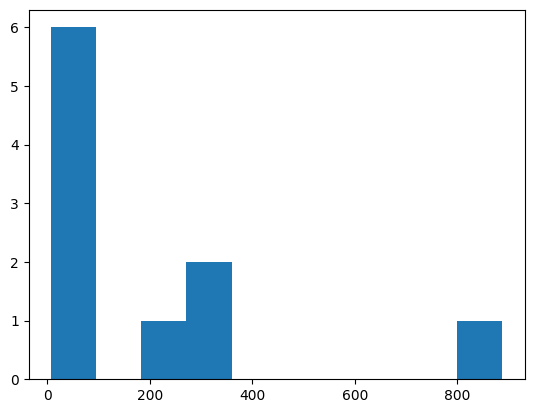

In [28]:
# Histogram of the errors
plt.hist(np.array(average_distance_from_truth))
plt.show()

In [33]:
# Average of the average, will be prone to outliers
print(f'Average Distance Between Trajectories: {np.mean(np.array(average_distance_from_truth))}')
print(f'Median Distance Between Trajectories: {np.median(np.array(average_distance_from_truth))}')

Average Distance Between Trajectories: 185.63321455885645
Median Distance Between Trajectories: 12.39617129562145
